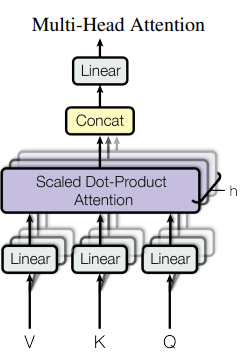

# Multi Head Attention

For MultiHeadAttention:
$$
\text{MultiHead}(Q,K,V) = Concat(head_1,...,head_h)W^O
$$

$$
\text{Where (head_i)} = \text{Attention}(QW_i^Q, KW_i^K, VW_i^2)
$$

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

In [ ]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size, sequence_length, input_dim))

In [ ]:
x.size()

torch.Size([1, 4, 512])

In [ ]:
qkv_layer = nn.Linear(input_dim , 3 * d_model)
qkv = qkv_layer(x)

In [ ]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

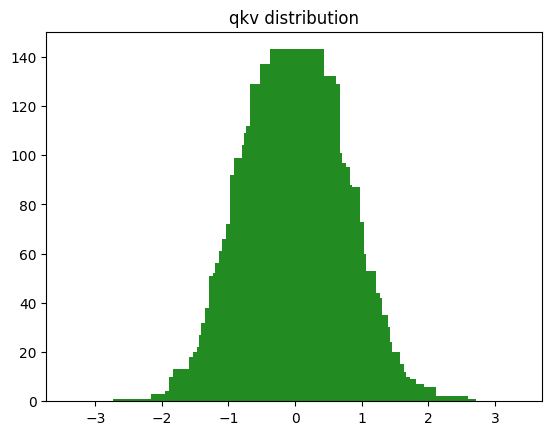

In [ ]:
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [ ]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [ ]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [ ]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [ ]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

# Self Attention for Multiple Heads

For a single head:
$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$

In [ ]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [ ]:
k.T.shape

<ipython-input-12-879c2705464e>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [ ]:
y = torch.randn(2,3)
torch.transpose(y, 0, 1)

tensor([[ 1.1124, -0.3430],
        [ 0.3021,  0.1179],
        [-0.6047, -0.0752]])

In [ ]:
torch.transpose(y, 1, 0)

tensor([[ 1.1124, -0.3430],
        [ 0.3021,  0.1179],
        [-0.6047, -0.0752]])

In [ ]:
k.transpose(-1, -2) == k.transpose(-2,-1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [ ]:
k.transpose(-1,-2).shape

torch.Size([1, 8, 64, 4])

In [ ]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] #mask for an input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [ ]:
(scaled + mask)[0][0]

tensor([[-0.1355,    -inf,    -inf,    -inf],
        [-0.0936, -0.4450,    -inf,    -inf],
        [-0.0324,  0.4344,  0.1747,    -inf],
        [ 0.0601,  0.0073,  0.1628, -0.9098]], grad_fn=<SelectBackward0>)

In [ ]:
scaled += mask

In [ ]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.404))

0.5388217044001664

In [ ]:
attention = F.softmax(scaled, dim=-1)

In [ ]:
attention.shape

torch.Size([1, 8, 4, 4])

In [ ]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5870, 0.4130, 0.0000, 0.0000],
        [0.2614, 0.4170, 0.3216, 0.0000],
        [0.2911, 0.2761, 0.3225, 0.1103]], grad_fn=<SelectBackward0>)

In [ ]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

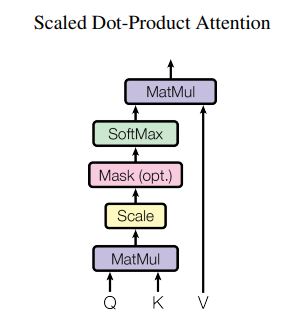

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [ ]:
values, attention = scaled_dot_product(q,k,v, mask=mask)

In [ ]:
attention.shape

torch.Size([1, 8, 4, 4])

In [ ]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5870, 0.4130, 0.0000, 0.0000],
        [0.2614, 0.4170, 0.3216, 0.0000],
        [0.2911, 0.2761, 0.3225, 0.1103]], grad_fn=<SelectBackward0>)

In [ ]:
values.size()

torch.Size([1, 8, 4, 64])

In [ ]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [ ]:
linear_layer = nn.Linear(d_model, d_model)

In [ ]:
output = linear_layer(values)

In [ ]:
output.shape

torch.Size([1, 4, 512])

In [ ]:
output

tensor([[[ 0.1644, -0.0597, -0.2637,  ..., -0.1137,  0.4839,  0.3814],
         [ 0.4021,  0.1434,  0.4260,  ...,  0.1468,  0.0582, -0.0248],
         [-0.1405, -0.4415, -0.2928,  ..., -0.0658,  0.2978,  0.0298],
         [ 0.1527, -0.0987, -0.4464,  ..., -0.1646, -0.1917, -0.3027]]],
       grad_fn=<ViewBackward0>)

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

In [ ]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
